In [1]:
import os
import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import zarr
from PIL import Image
from squircle import Squircle

def absoluteFilePaths(directory:str):
    # Credits: https://stackoverflow.com/questions/9816816/get-absolute-paths-of-all-files-in-a-directory
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))


DATA_DIRECTORY = "/cluster/projects/itea_lille-nv-fys/TFY4330_nanotools/Grp11"
ZSPY_FILES_DIRECTORY = "data/zspy"

names_with_magnetism = []

dm3: dict[str, str] = {}
hdr: dict[str, str] = {}
mib: dict[str, str] = {}

for filepath in absoluteFilePaths(DATA_DIRECTORY):
    file = filepath.split("/")[-1].split(".")
    (name, file_extension) = file[0], file[-1]

    if file_extension == "mib":
        mib[name] = filepath
        names_with_magnetism.append(name)
    elif file_extension == "hdr":
        hdr[name] = filepath
    elif file_extension == "dm3":
        dm3[name] = filepath

os.makedirs(ZSPY_FILES_DIRECTORY, exist_ok=True)

name_to_bitmap = {
    "...":"bitmaps/bitmap-size-[200 200 260 260]nm.bmp",
    "...":"bitmaps/bitmap-size-[320 320 380 380]nm.bmp",
    "...":"bitmaps/bitmap-size-[440 440 500 500]nm.bmp",
}

names_with_magnetism.sort()

if "008" in names_with_magnetism:
    names_with_magnetism.remove("008") # Remove magnetic compass


In [2]:
%matplotlib widget
from pathlib import Path
import os
import hyperspy.api as hs


stem_folder = Path("data/stem-images")

os.makedirs(str(stem_folder), exist_ok=True)

for name in names_with_magnetism:
    s = hs.load(dm3[name])
    fig, ax = plt.subplots()
    cax = ax.imshow(s.data, cmap="gray", vmin=0, vmax=255)

    scale = s.axes_manager[0].scale
    #print(f"name:{name}, scale:{round(scale, 4)}")
    
    fig.savefig(f"stem-images/{name}-stem.png")

In [3]:
%matplotlib inline
import pyxem

def get_magnetic_data(name) -> pyxem.signals.BeamShift:
    s = hs.load(dm3[name])
    
    filepath = Path(ZSPY_FILES_DIRECTORY).joinpath(f"{name}.zspy")
    if not filepath.exists():
        s_4d = hs.load(mib[name], lazy=True, navigation_shape=(s.axes_manager[0].size + 1, s.axes_manager[1].size))
        s_4d_crop = s_4d.inav[:-1]
    
        for i in range(2):
            s_4d_crop.axes_manager[i].scale = s.axes_manager[i].scale
            s_4d_crop.axes_manager[i].unit = s.axes_manager[i].units
    
        s_4d_crop.axes_manager[0].name = "Probe x"
        s_4d_crop.axes_manager[1].name = "Probe y"
        s_4d_crop.axes_manager[2].name = "Diffraction x"
        s_4d_crop.axes_manager[3].name = "Diffraction y"
    
        store = zarr.ZipStore(str(filepath))
        s_4d_crop.save(store, chunks=(64,64,64,64))
    
    s_magnetic = hs.load(str(filepath), lazy=True)
    s_magnetic_sum = s_magnetic.sum(axis=(-1,-2))
    s_magnetic_nav = s_magnetic_sum.transpose
    s_magnetic.navigator = s_magnetic_nav
    
    s_magnetic_bs = s_magnetic.get_direct_beam_position(method="center_of_mass")
    s_magnetic_bs.compute()
    #s_magnetic_bs.plot()
    
    s_magnetic_bs_lp = s_magnetic_bs.get_linear_plane()
    
    s_magnetic_bs_corr = s_magnetic_bs - s_magnetic_bs_lp

    return s_magnetic_bs_corr

Figures for 002


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:56:96---32:72
slice values:56:96---83:123
slice values:56:96---135:175
slice values:56:96---185:225
slice values:131:171---32:72
slice values:130:170---84:124
slice values:130:170---137:177
slice values:128:168---187:227
slice values:205:245---34:74
slice values:206:246---85:125
slice values:204:244---136:176
slice values:205:245---186:226
slice values:279:319---34:74
slice values:278:318---85:125
slice values:279:319---138:178
slice values:279:319---188:228
slice values:353:393---36:76
slice values:352:392---86:126
slice values:352:392---138:178
slice values:352:392---188:228
slice values:426:466---35:75


/tmp/ipykernel_875445/4058975128.py:231: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


slice values:428:468---86:126
slice values:427:467---138:178
slice values:426:466---190:230
Figures for 003


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:47:87---15:55
slice values:46:86---72:112
slice values:46:86---126:166
slice values:46:86---180:220
slice values:125:165---15:55
slice values:125:165---72:112
slice values:125:165---127:167
slice values:124:164---182:222
slice values:203:243---17:57
slice values:204:244---73:113
slice values:204:244---127:167
slice values:203:243---182:222
slice values:282:322---19:59
slice values:281:321---74:114
slice values:282:322---128:168
slice values:282:322---182:222
slice values:360:400---20:60
slice values:360:400---73:113
slice values:359:399---129:169
slice values:360:400---182:222
slice values:439:479---21:61
slice values:439:479---75:115
slice values:439:479---130:170
slice values:438:478---184:224
Figures for 004


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:33:73---10:50
slice values:32:72---65:105
slice values:32:72---120:160
slice values:32:72---173:213
slice values:110:150---10:50
slice values:110:150---65:105
slice values:110:150---121:161
slice values:110:150---175:215
slice values:188:228---11:51
slice values:188:228---66:106
slice values:188:228---122:162
slice values:188:228---175:215
slice values:268:308---12:52
slice values:267:307---66:106
slice values:267:307---122:162
slice values:267:307---176:216
slice values:346:386---14:54
slice values:346:386---67:107
slice values:345:385---122:162
slice values:346:386---176:216
slice values:426:466---15:55
slice values:425:465---68:108
slice values:426:466---123:163
slice values:424:464---177:217
Figures for 005


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:48:88---16:56
slice values:47:87---70:110
slice values:48:88---125:165
slice values:48:88---179:219
slice values:126:166---16:56
slice values:126:166---70:110
slice values:126:166---124:164
slice values:125:165---179:219
slice values:205:245---16:56
slice values:205:245---71:111
slice values:205:245---126:166
slice values:204:244---179:219
slice values:283:323---17:57
slice values:282:322---72:112
slice values:282:322---127:167
slice values:282:322---180:220
slice values:362:402---18:58
slice values:362:402---72:112
slice values:361:401---127:167
slice values:360:400---180:220
slice values:442:482---19:59
slice values:441:481---73:113
slice values:440:480---127:167
slice values:441:481---181:221
Figures for 006


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:49:89---19:59
slice values:48:88---71:111
slice values:48:88---120:160
slice values:49:89---172:212
slice values:122:162---19:59
slice values:122:162---70:110
slice values:122:162---123:163
slice values:122:162---173:213
slice values:196:236---20:60
slice values:196:236---72:112
slice values:197:237---124:164
slice values:196:236---174:214
slice values:271:311---21:61
slice values:272:312---72:112
slice values:271:311---124:164
slice values:272:312---175:215
slice values:343:383---22:62
slice values:344:384---73:113
slice values:345:385---125:165
slice values:343:383---175:215
slice values:418:458---24:64
slice values:418:458---73:113
slice values:418:458---126:166
slice values:418:458---175:215
Figures for 007


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:50:90---9:49
slice values:51:91---61:101
slice values:51:91---112:152
slice values:50:90---164:204
slice values:124:164---9:49
slice values:124:164---59:99
slice values:123:163---113:153
slice values:123:163---163:203
slice values:199:239---11:51
slice values:198:238---61:101
slice values:197:237---113:153
slice values:198:238---164:204
slice values:272:312---10:50
slice values:272:312---62:102
slice values:269:309---113:153
slice values:270:310---164:204
slice values:347:387---13:53
slice values:346:386---63:103
slice values:346:386---114:154
slice values:344:384---165:205
slice values:419:459---12:52
slice values:419:459---63:103
slice values:419:459---114:154
slice values:419:459---164:204
Figures for 009


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:24:64---15:55
slice values:22:62---70:110
slice values:22:62---125:165
slice values:21:61---179:219
slice values:102:142---16:56
slice values:102:142---72:112
slice values:101:141---126:166
slice values:101:141---181:221
slice values:180:220---17:57
slice values:180:220---73:113
slice values:180:220---127:167
slice values:179:219---182:222
slice values:259:299---19:59
slice values:259:299---74:114
slice values:259:299---128:168
slice values:259:299---182:222
slice values:337:377---21:61
slice values:337:377---74:114
slice values:337:377---129:169
slice values:337:377---182:222
slice values:416:456---22:62
slice values:417:457---75:115
slice values:416:456---130:170
slice values:416:456---184:224
Figures for 010


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:35:75---13:53
slice values:34:74---68:108
slice values:34:74---122:162
slice values:34:74---177:217
slice values:112:152---14:54
slice values:112:152---69:109
slice values:112:152---125:165
slice values:112:152---179:219
slice values:192:232---15:55
slice values:192:232---70:110
slice values:191:231---125:165
slice values:190:230---179:219
slice values:271:311---16:56
slice values:271:311---71:111
slice values:270:310---126:166
slice values:270:310---180:220
slice values:349:389---18:58
slice values:348:388---71:111
slice values:348:388---126:166
slice values:348:388---180:220
slice values:429:469---20:60
slice values:429:469---73:113
slice values:429:469---127:167
slice values:428:468---181:221
Figures for 011


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:31:71---19:59
slice values:30:70---73:113
slice values:32:72---127:167
slice values:31:71---180:220
slice values:110:150---20:60
slice values:110:150---72:112
slice values:110:150---127:167
slice values:109:149---182:222
slice values:190:230---20:60
slice values:190:230---74:114
slice values:190:230---130:170
slice values:189:229---182:222
slice values:268:308---21:61
slice values:268:308---75:115
slice values:268:308---130:170
slice values:268:308---182:222
slice values:347:387---22:62
slice values:347:387---76:116
slice values:346:386---131:171
slice values:346:386---185:225
slice values:426:466---23:63
slice values:426:466---77:117
slice values:426:466---132:172
slice values:426:466---186:226
Figures for 012


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:31:71---20:60
slice values:29:69---74:114
slice values:31:71---129:169
slice values:30:70---182:222
slice values:110:150---21:61
slice values:110:150---74:114
slice values:110:150---129:169
slice values:109:149---184:224
slice values:190:230---22:62
slice values:190:230---75:115
slice values:189:229---132:172
slice values:189:229---184:224
slice values:268:308---22:62
slice values:268:308---76:116
slice values:268:308---132:172
slice values:268:308---184:224
slice values:347:387---24:64
slice values:346:386---77:117
slice values:346:386---133:173
slice values:345:385---186:226
slice values:426:466---24:64
slice values:425:465---78:118
slice values:425:465---133:173
slice values:425:465---187:227
Figures for 013


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:43:83---26:66
slice values:43:83---77:117
slice values:42:82---127:167
slice values:41:81---178:218
slice values:117:157---27:67
slice values:117:157---78:118
slice values:117:157---131:171
slice values:115:155---180:220
slice values:193:233---28:68
slice values:192:232---79:119
slice values:191:231---131:171
slice values:192:232---180:220
slice values:266:306---28:68
slice values:266:306---80:120
slice values:266:306---132:172
slice values:265:305---182:222
slice values:339:379---30:70
slice values:338:378---81:121
slice values:338:378---132:172
slice values:338:378---183:223
slice values:413:453---29:69
slice values:414:454---81:121
slice values:414:454---133:173
slice values:413:453---185:225
Figures for 014


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:39:79---36:76
slice values:39:79---88:128
slice values:37:77---138:178
slice values:36:76---189:229
slice values:112:152---37:77
slice values:112:152---88:128
slice values:112:152---141:181
slice values:110:150---190:230
slice values:187:227---38:78
slice values:186:226---89:129
slice values:185:225---141:181
slice values:186:226---190:230
slice values:260:300---38:78
slice values:260:300---90:130
slice values:260:300---142:182
slice values:259:299---192:232
slice values:334:374---40:80
slice values:333:373---90:130
slice values:333:373---142:182
slice values:332:372---193:233
slice values:408:448---39:79
slice values:409:449---91:131
slice values:408:448---143:183
slice values:408:448---195:235
Figures for 015


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:51:91---17:57
slice values:49:89---70:110
slice values:50:90---119:159
slice values:49:89---171:211
slice values:124:164---18:58
slice values:124:164---71:111
slice values:124:164---122:162
slice values:123:163---172:212
slice values:198:238---20:60
slice values:199:239---71:111
slice values:199:239---123:163
slice values:198:238---173:213
slice values:272:312---21:61
slice values:272:312---73:113
slice values:272:312---123:163
slice values:272:312---175:215
slice values:344:384---22:62
slice values:346:386---73:113
slice values:346:386---124:164
slice values:344:384---174:214
slice values:420:460---24:64
slice values:419:459---73:113
slice values:420:460---125:165
slice values:420:460---176:216
Figures for 016


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:55:95---16:56
slice values:56:96---67:107
slice values:56:96---118:158
slice values:54:94---170:210
slice values:130:170---16:56
slice values:129:169---66:106
slice values:129:169---119:159
slice values:130:170---169:209
slice values:205:245---18:58
slice values:204:244---68:108
slice values:203:243---119:159
slice values:204:244---170:210
slice values:277:317---18:58
slice values:278:318---69:109
slice values:274:314---120:160
slice values:276:316---171:211
slice values:354:394---20:60
slice values:352:392---71:111
slice values:351:391---121:161
slice values:350:390---171:211
slice values:427:467---20:60
slice values:427:467---69:109
slice values:426:466---121:161
slice values:425:465---172:212
Figures for 017


  0%|          | 0/225 [00:00<?, ?it/s]

slice values:56:96---23:63
slice values:56:96---74:114
slice values:56:96---126:166
slice values:55:95---177:217
slice values:131:171---24:64
slice values:130:170---74:114
slice values:130:170---127:167
slice values:131:171---177:217
slice values:206:246---26:66
slice values:205:245---76:116
slice values:204:244---127:167
slice values:205:245---178:218
slice values:278:318---26:66
slice values:278:318---77:117
slice values:275:315---128:168
slice values:276:316---180:220
slice values:354:394---28:68
slice values:353:393---80:120
slice values:352:392---130:170
slice values:351:391---179:219
slice values:428:468---29:69
slice values:427:467---78:118
slice values:426:466---130:170
slice values:425:465---181:221


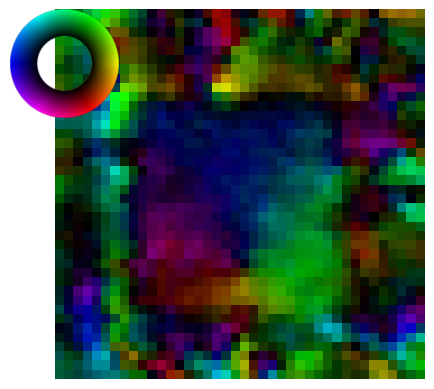

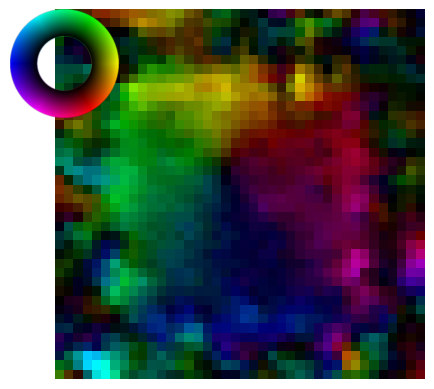

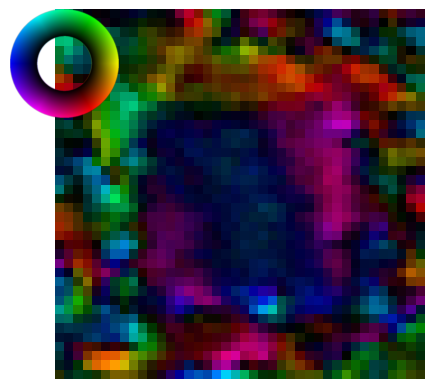

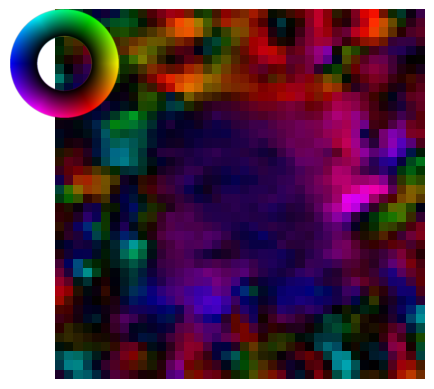

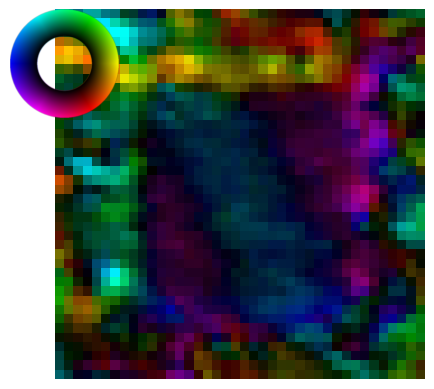

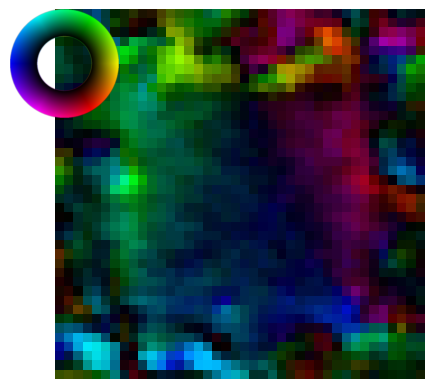

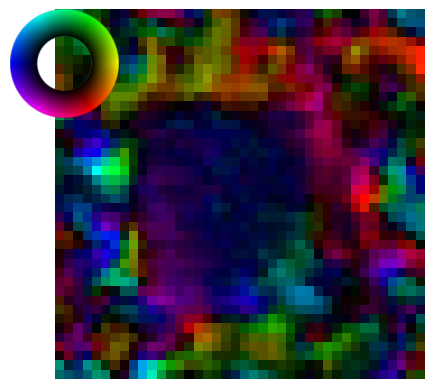

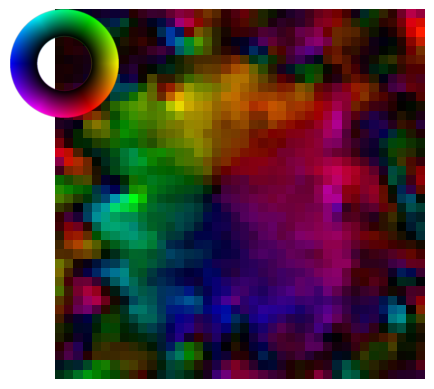

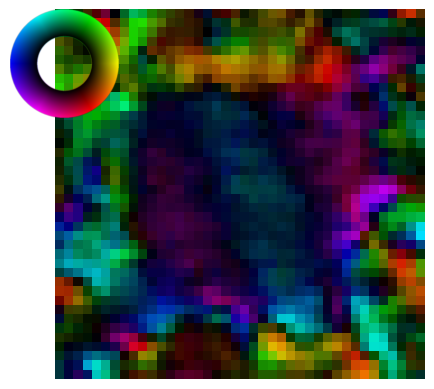

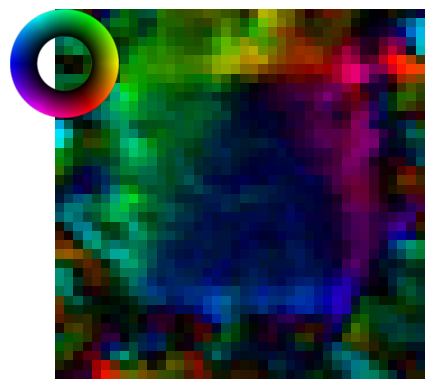

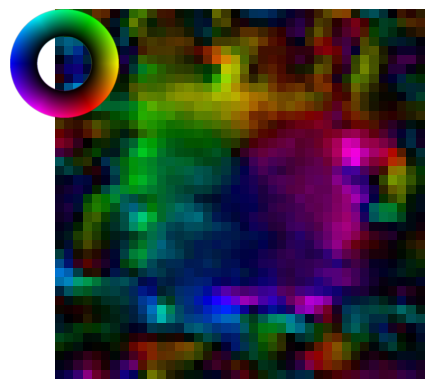

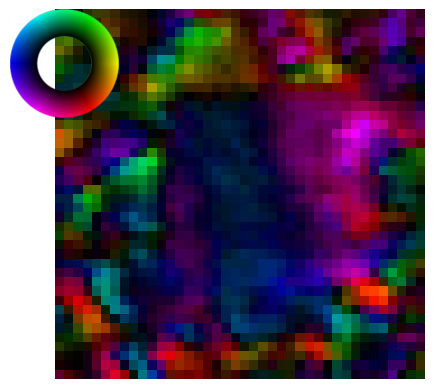

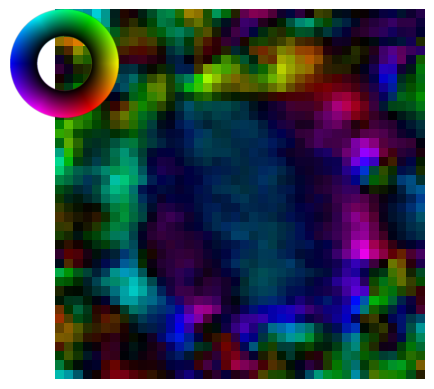

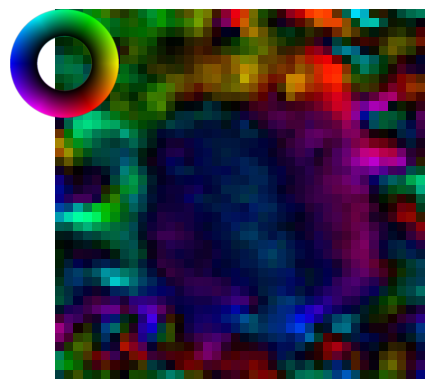

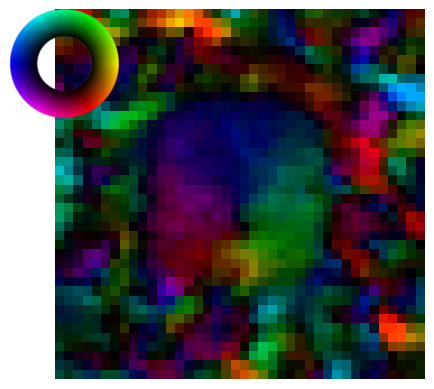

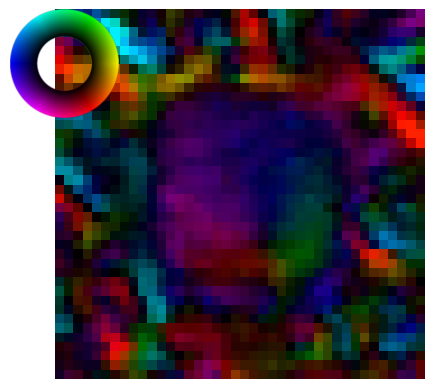

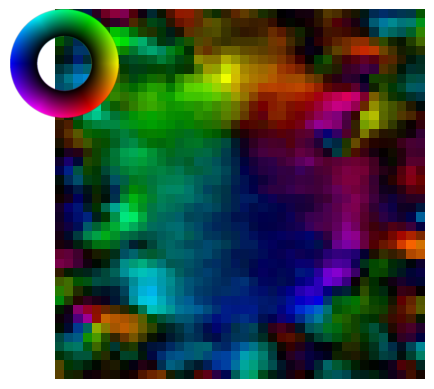

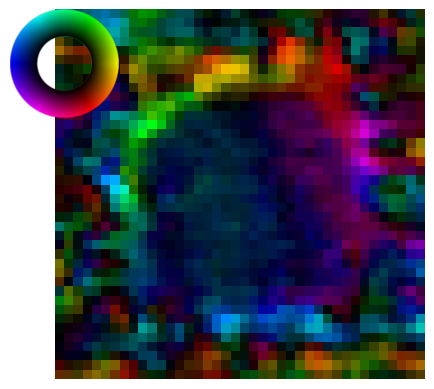

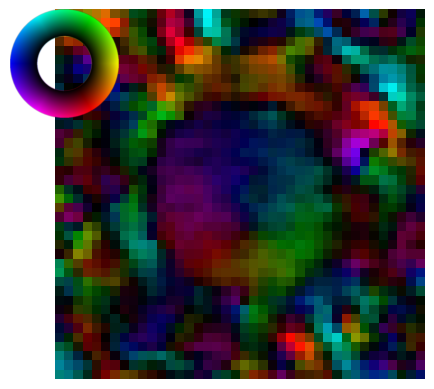

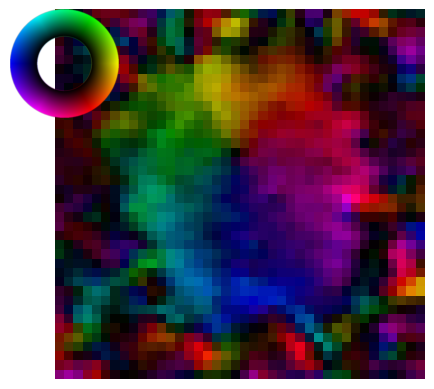

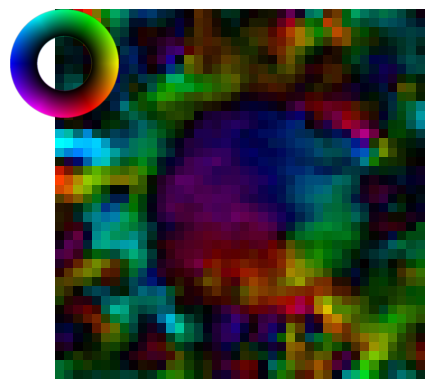

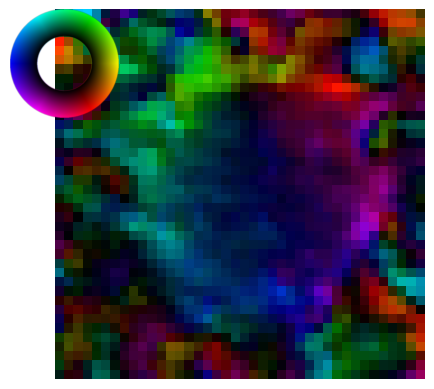

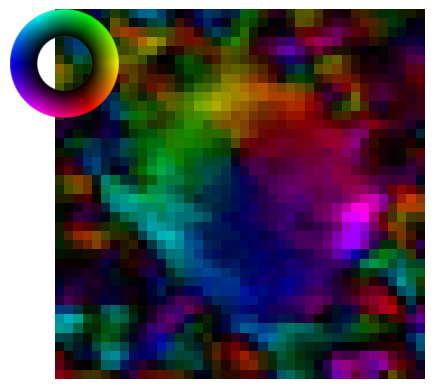

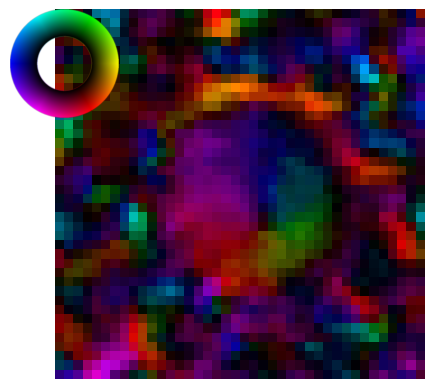

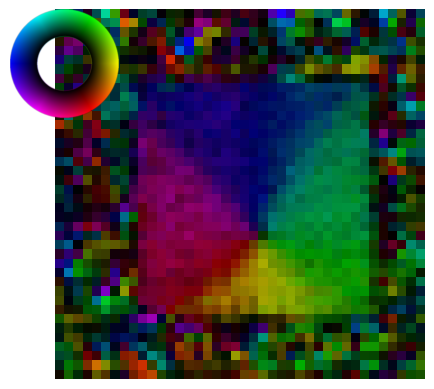

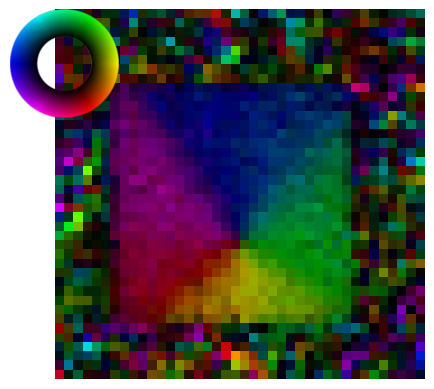

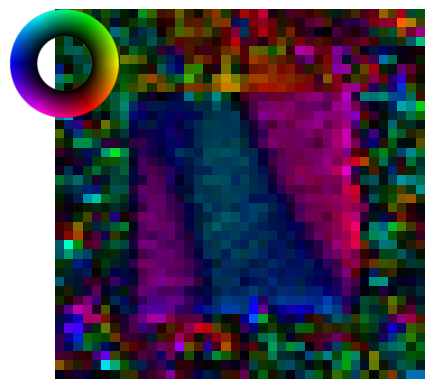

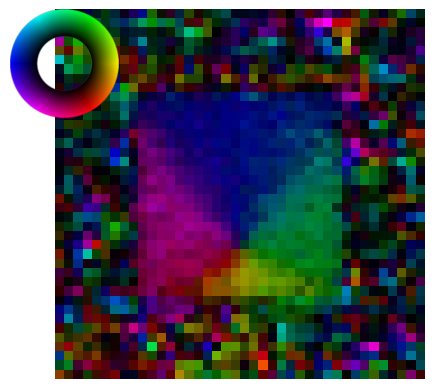

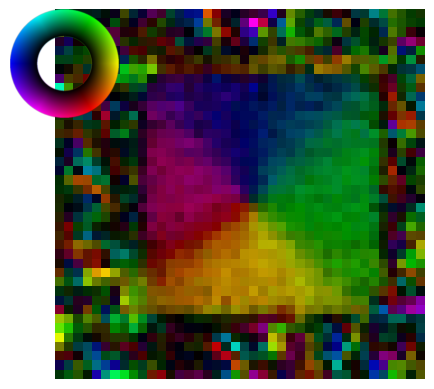

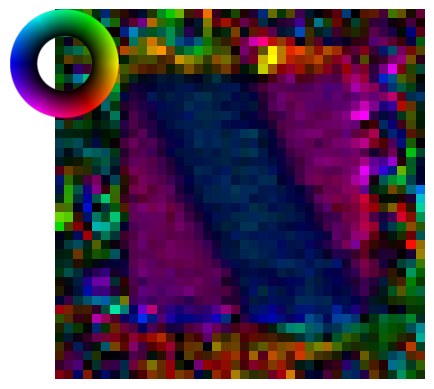

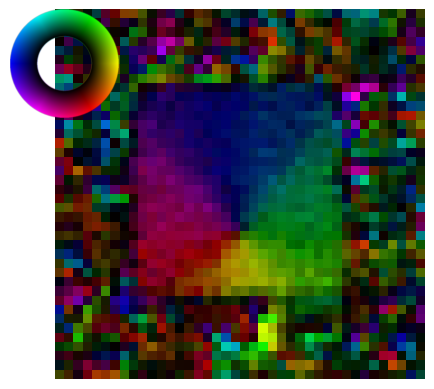

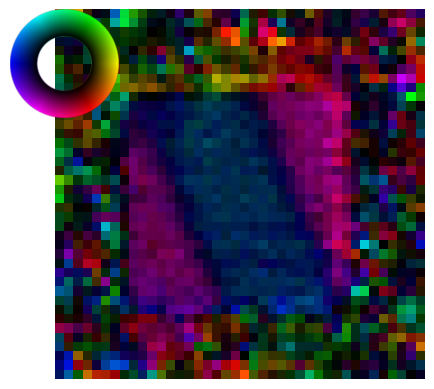

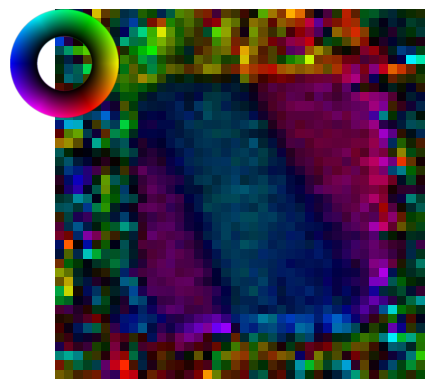

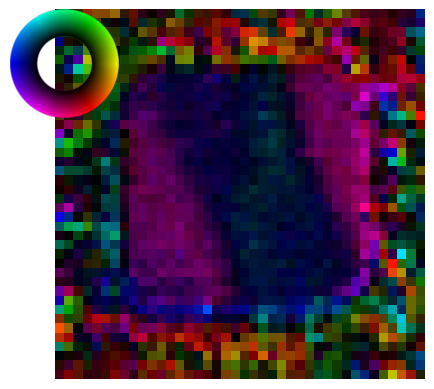

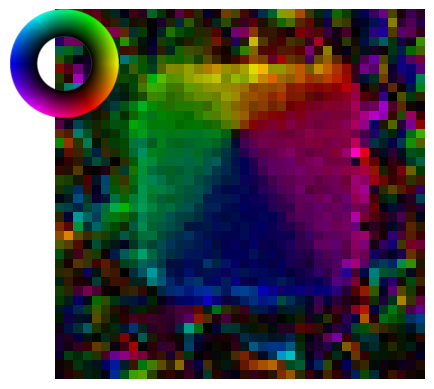

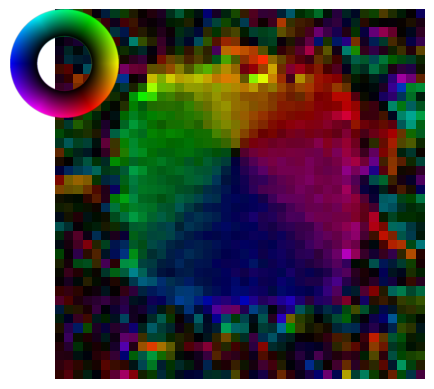

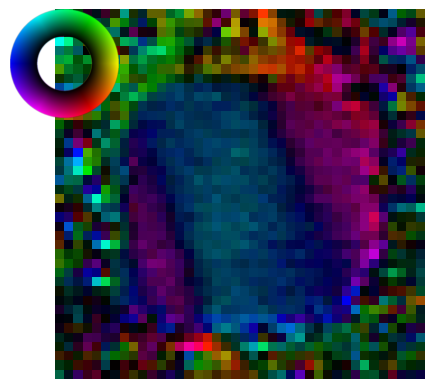

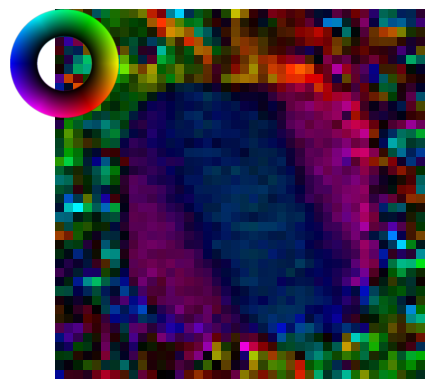

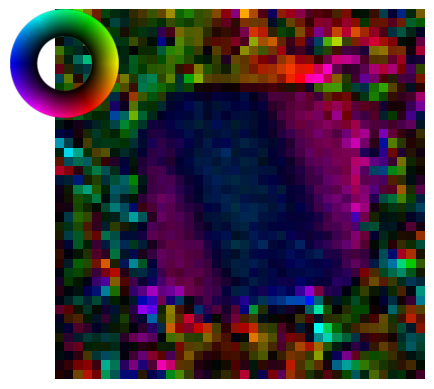

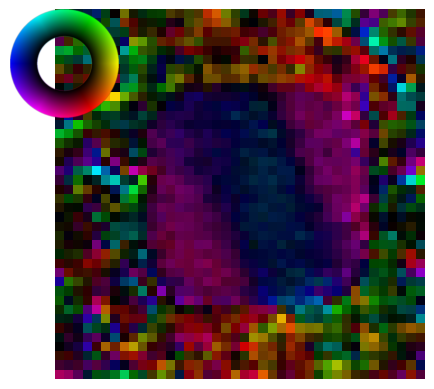

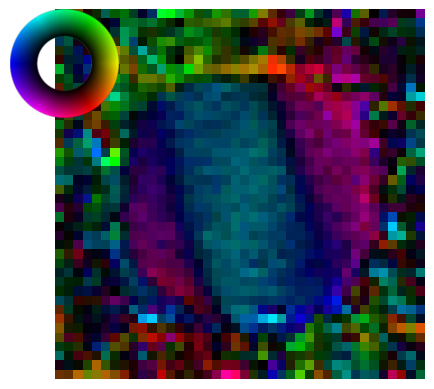

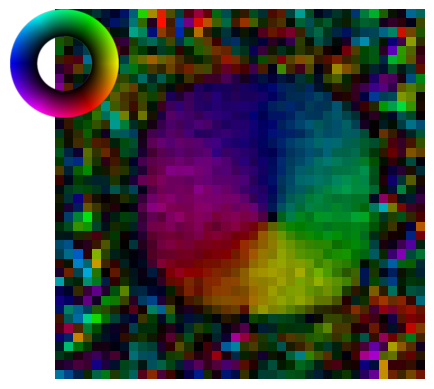

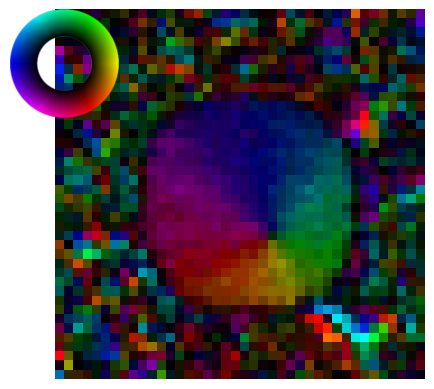

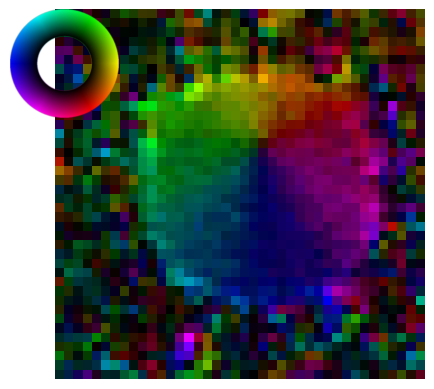

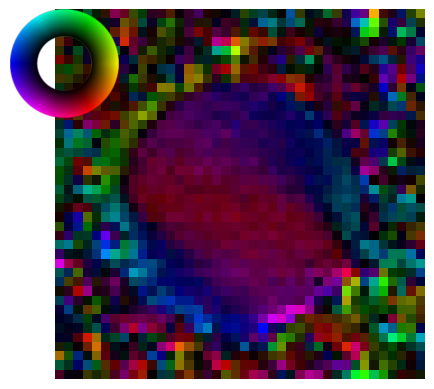

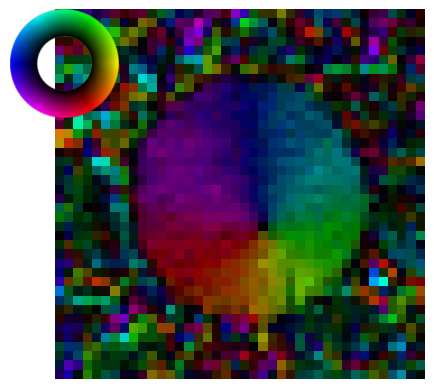

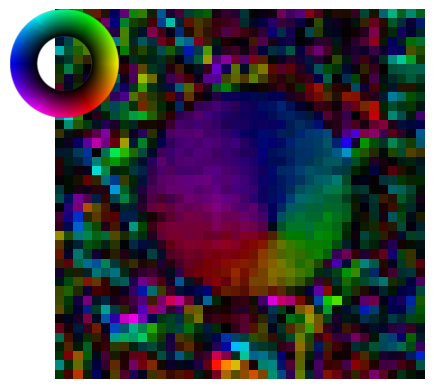

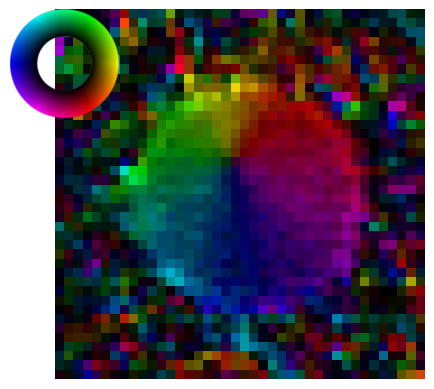

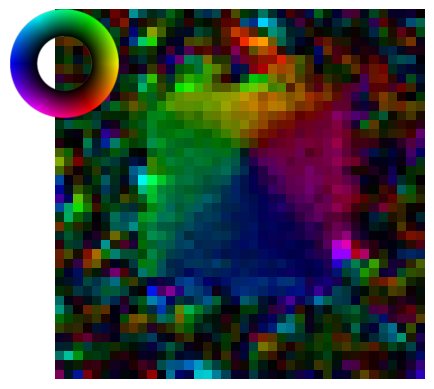

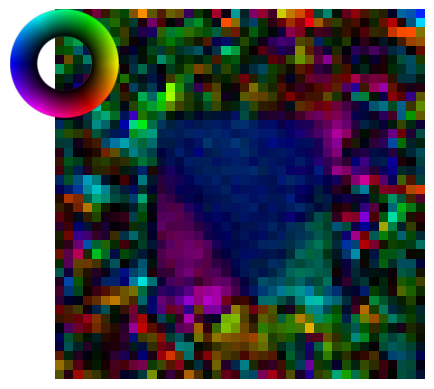

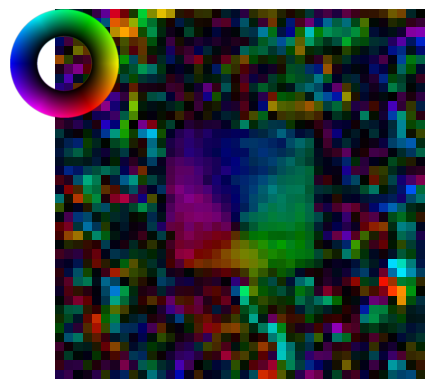

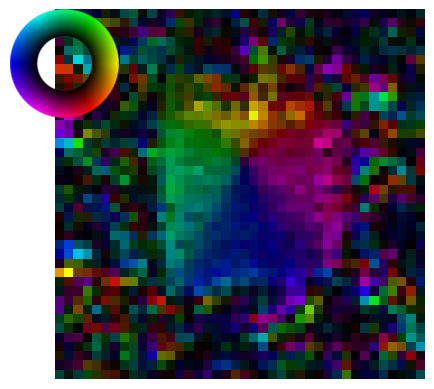

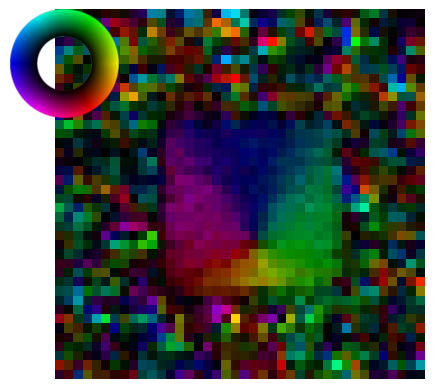

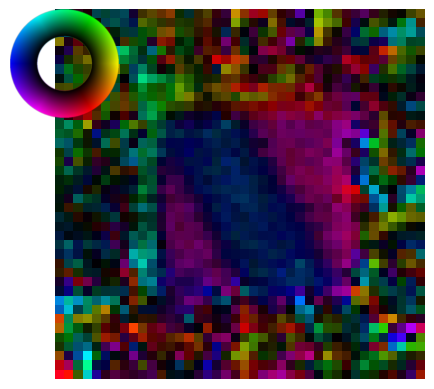

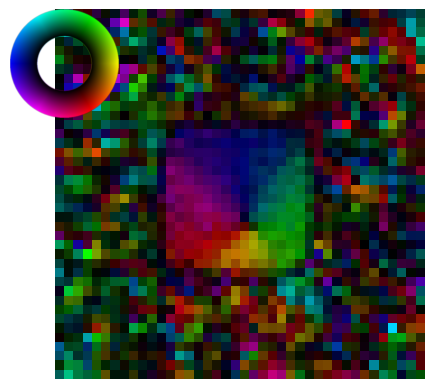

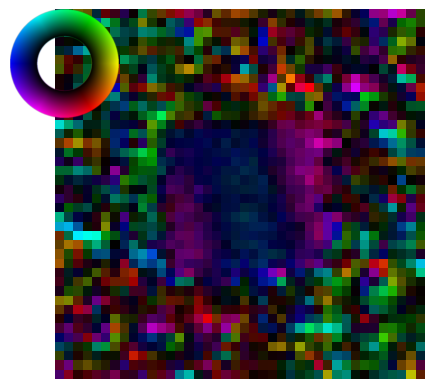

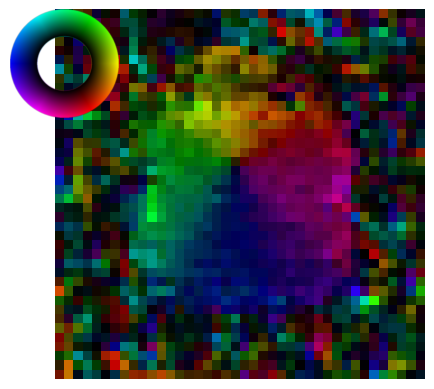

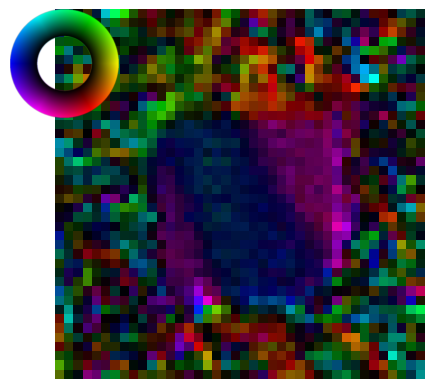

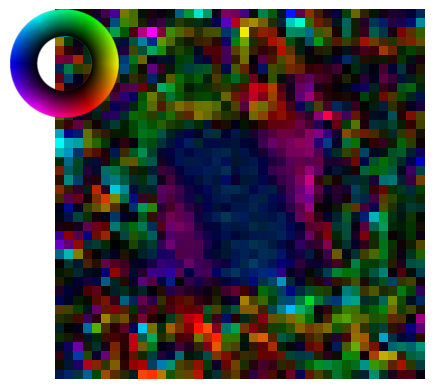

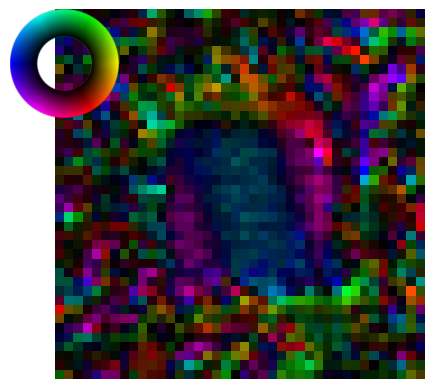

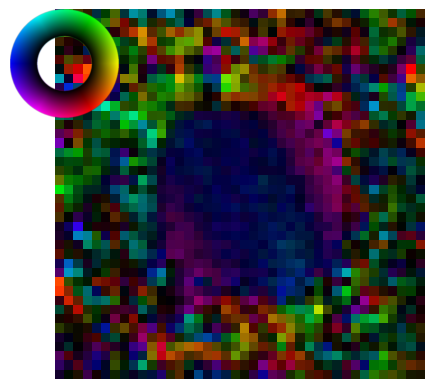

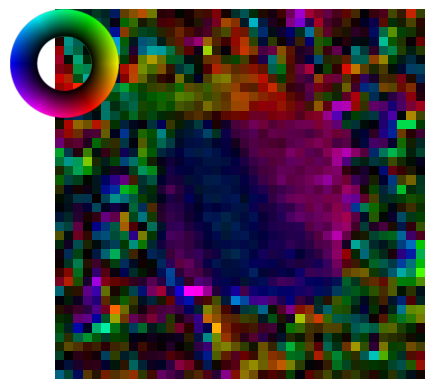

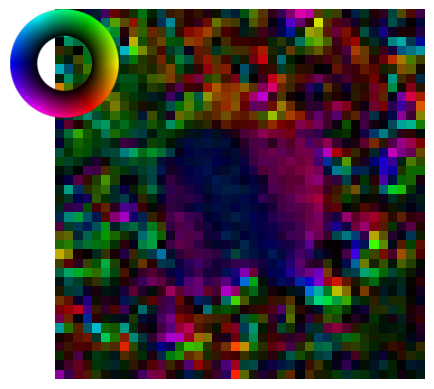

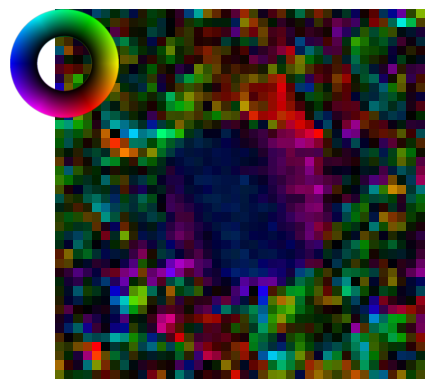

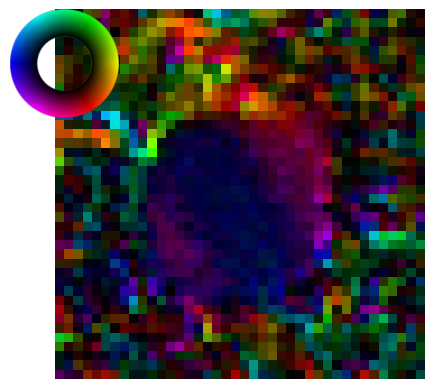

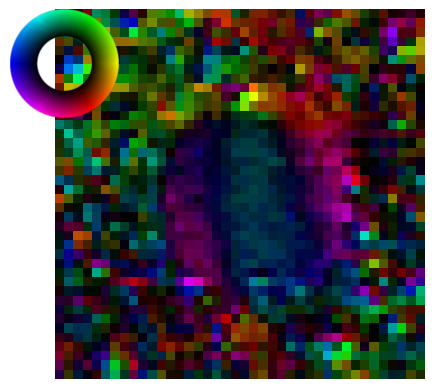

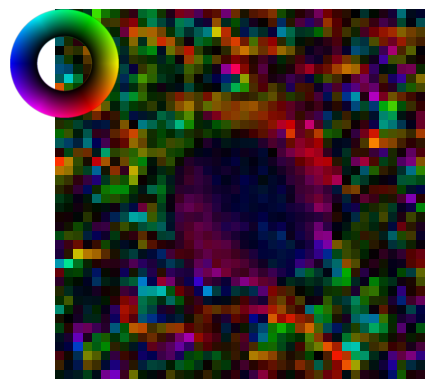

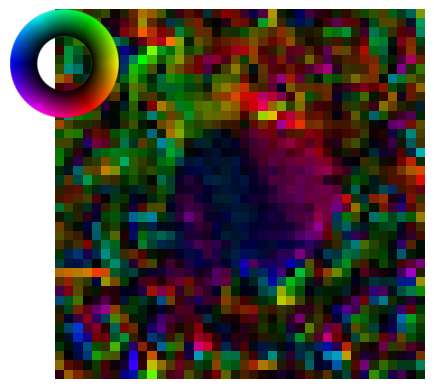

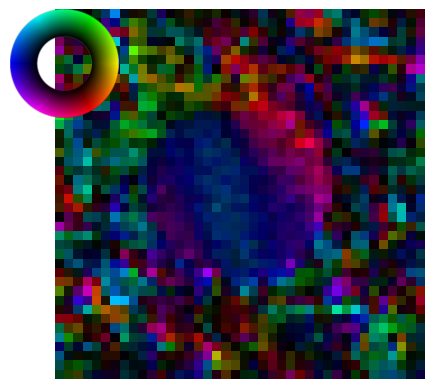

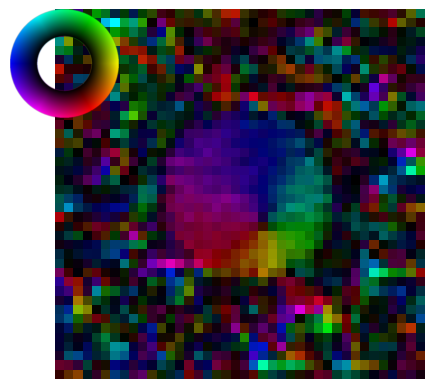

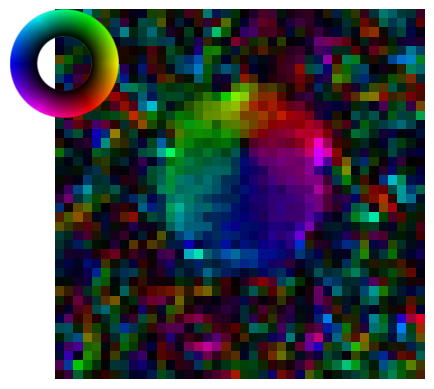

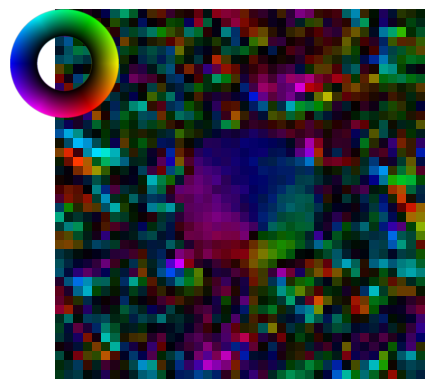

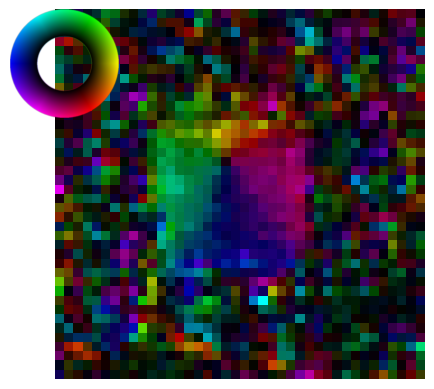

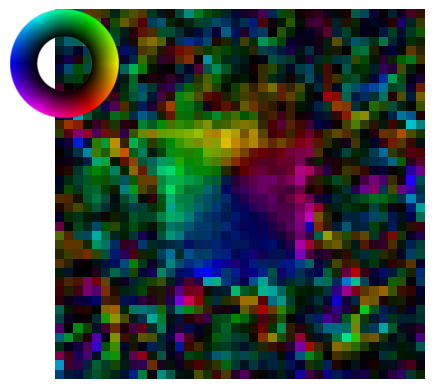

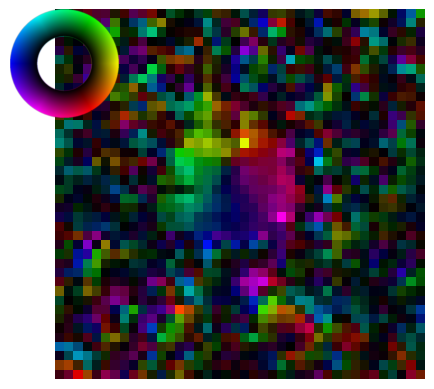

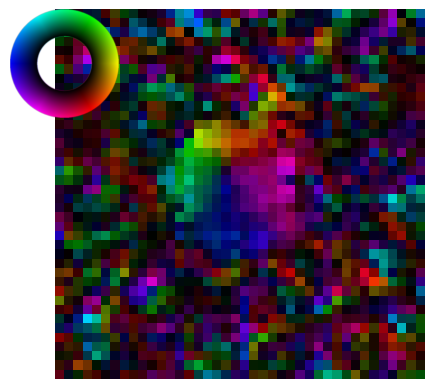

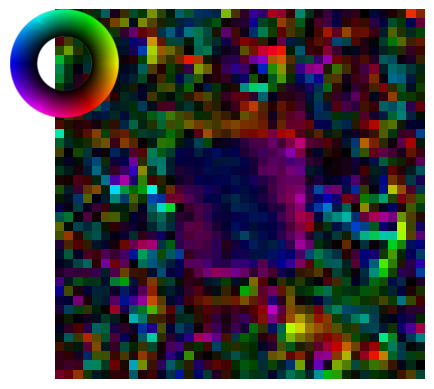

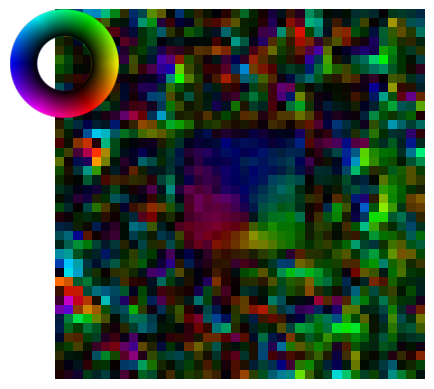

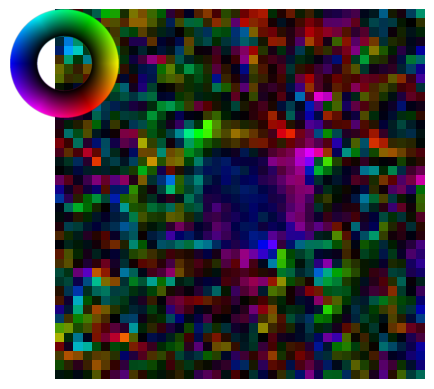

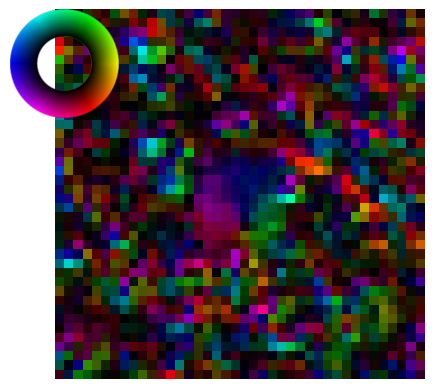

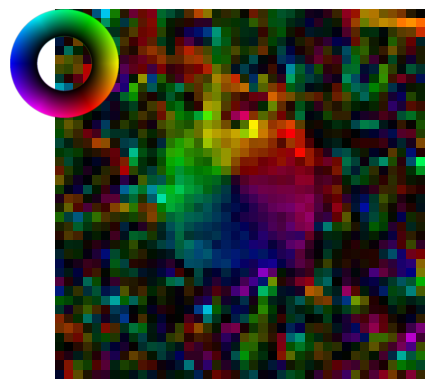

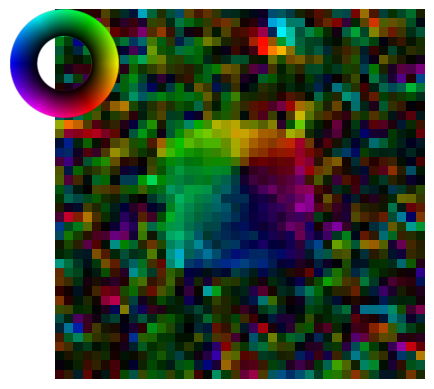

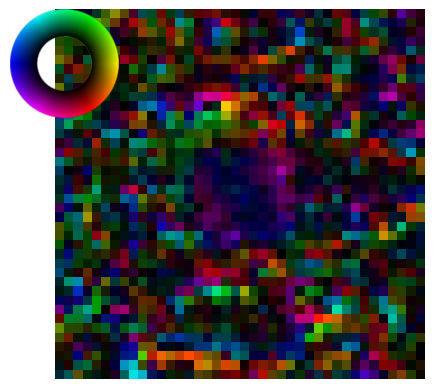

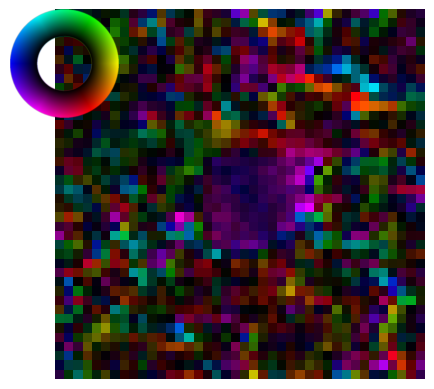

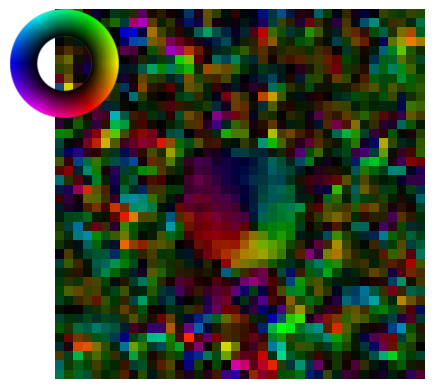

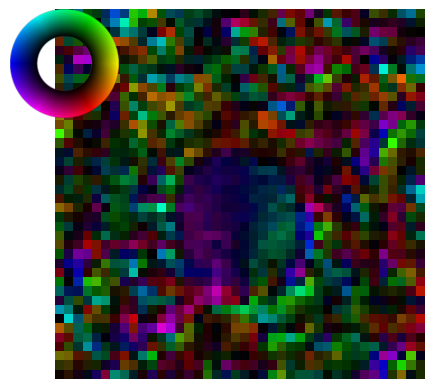

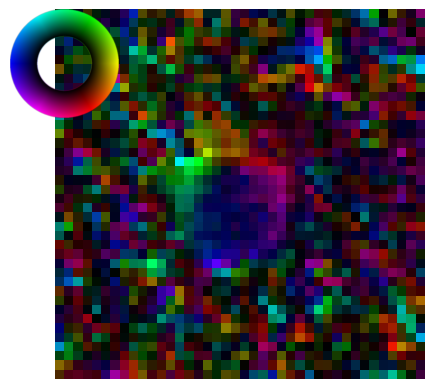

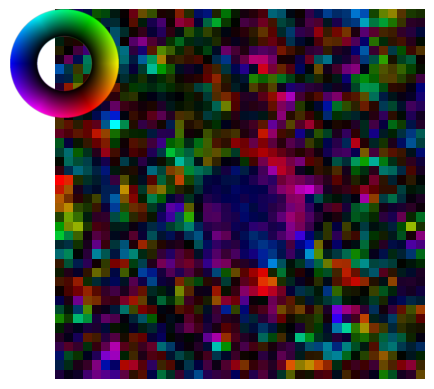

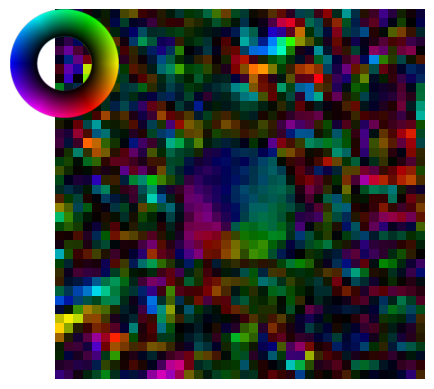

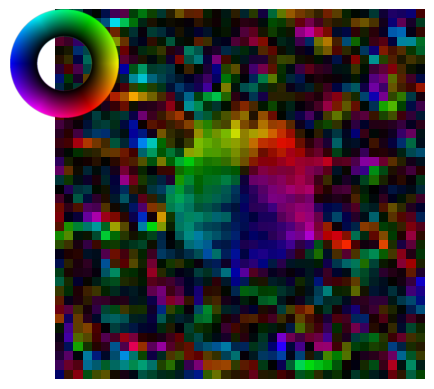

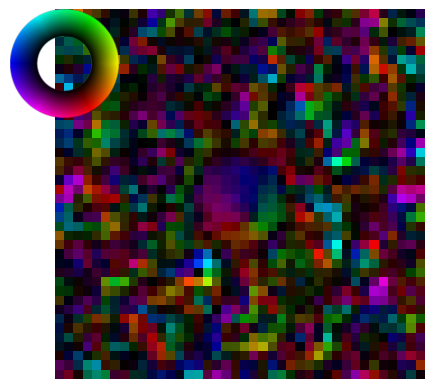

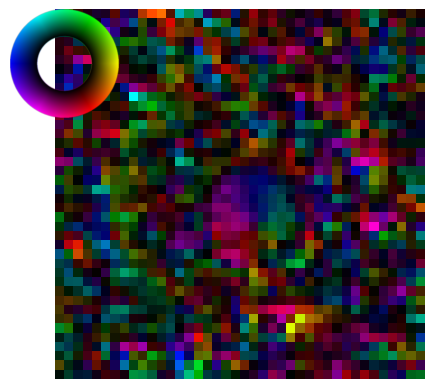

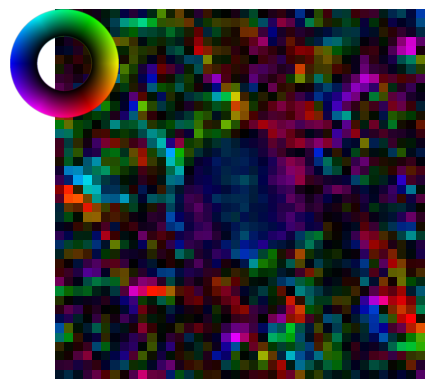

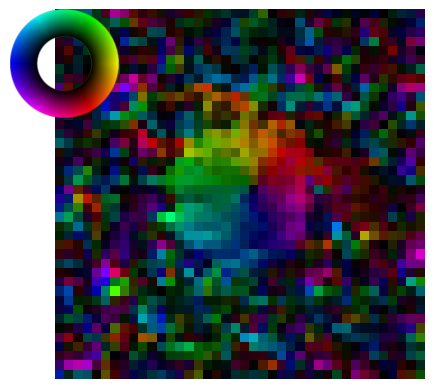

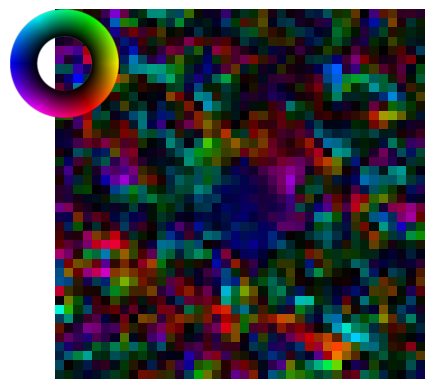

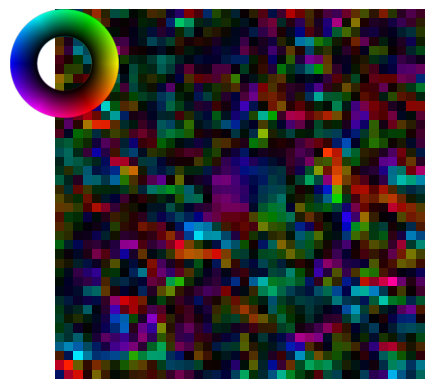

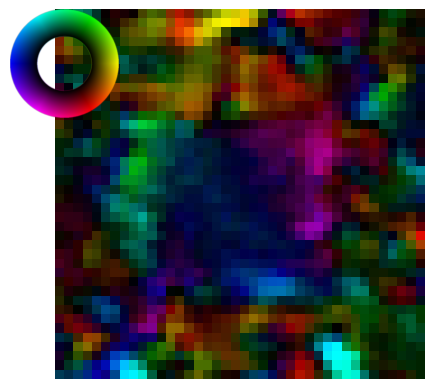

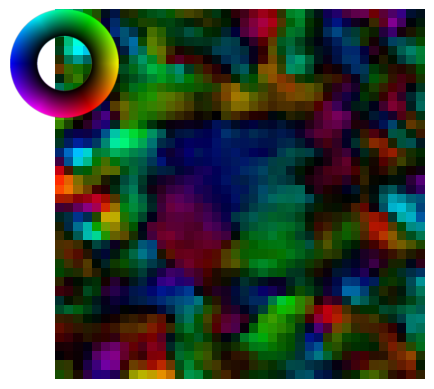

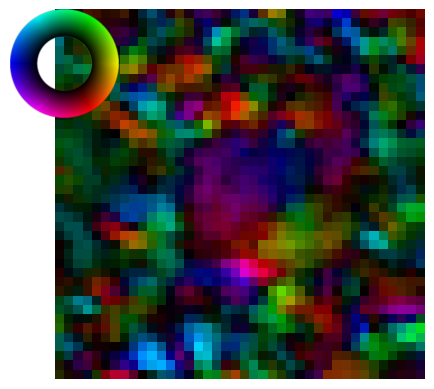

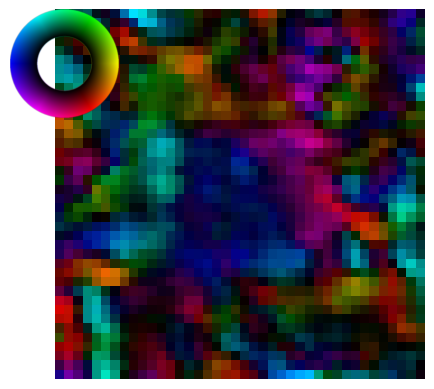

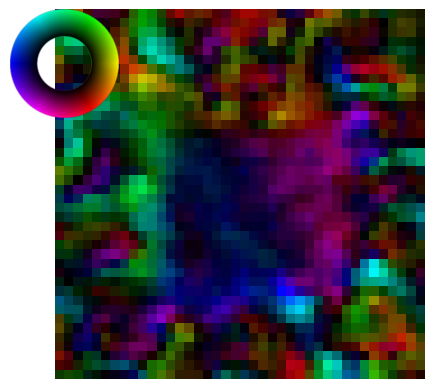

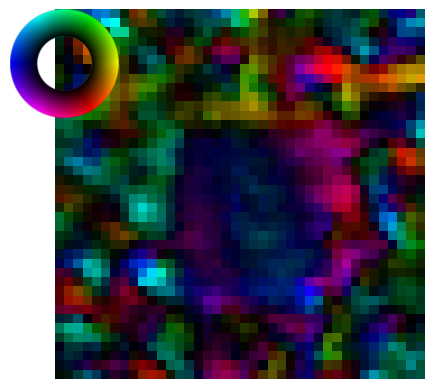

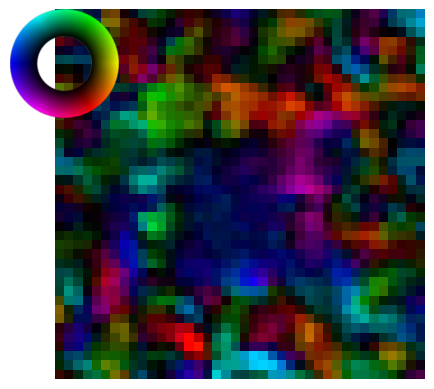

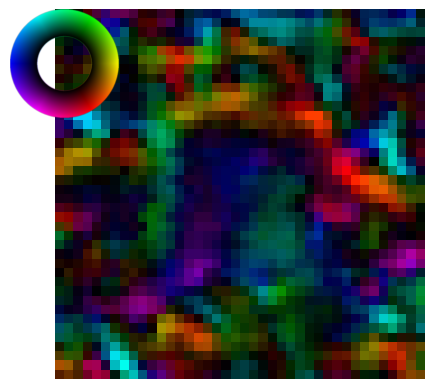

In [ ]:
##### import numpy as np
import hyperspy.api as hs
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter
from collections import defaultdict
from pathlib import Path
import pyxem as pxm



SHOW_POSITIONS = False
MAGNETIC_DATA_FOLDER = Path("data/magnetic-data")

def find_center_of_mass(array):
    total_y = 0
    total_x = 0

    c = 2**5
    
    normalisation = np.sum(array/c)

    for y in range(array.shape[0]):
        for x in range(array.shape[1]):
            total_x += x*c*(array[y,x]/normalisation)
            total_y += y*c*(array[y,x]/normalisation)
            
    return np.array([round(total_x), round(total_y)])

def find_peaks(signal, limit=(1/3)):
    threshold = (np.max(signal))*limit
    peaks = []
    x0 = None

    
    for x in np.arange(signal.shape[0]):
        if (signal[x]) > threshold and x0==None:
            x0 = x

        if (signal[x]) < threshold and x0!=None:
            peaks.append(round((x+x0)/2))
            x0 = None
    return peaks

# Credit: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-mas
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()


def fit_gaussian(data, plot=False):
    # Create x and y indices
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    
    #create data
    initial_data = twoD_Gaussian((x, y), 2,int(data.shape[1]/2),int(data.shape[0]/2),5,5,0,1)
    
    # plot twoD_Gaussian data generated above
    #plt.figure()
    #plt.imshow(initial_data.reshape(data.shape[1]+1, data.shape[0]+1))
    #plt.colorbar()

    # add some noise to the data and try to fit the data generated beforehand
    initial_guess = (2,int(data.shape[1]/2),int(data.shape[0]/2),5,5,0,10)

    flatten_data = data.flatten()
    
    #data_noisy = initial_data + 0.2*np.random.normal(size=initial_data.shape)
    
    popt, pcov = curve_fit(twoD_Gaussian, (x, y), flatten_data, p0=initial_guess, maxfev = 5000)


    if plot:
        data_fitted = twoD_Gaussian((x, y), *popt)

        
        fig, ax = plt.subplots(1, 1)
        #ax.hold(True) For older versions. This has now been deprecated and later removed
        ax.imshow(flatten_data.reshape(data.shape[1], data.shape[0]), cmap=plt.cm.jet, origin='lower',
            extent=(x.min(), x.max(), y.min(), y.max()))
        ax.contour(x, y, data_fitted.reshape(data.shape[1], data.shape[0]), 8, colors='w')
        plt.show()
    
    return (popt[1]-data.shape[1]/2, popt[2]-data.shape[0]/2)



cap = defaultdict(lambda:0.87)
cap["005"] = 0.92
cap["017"] = 0.90


name_to_width = {
    "002": (220, 250),
    "003": (440, 500),
    "004": (320, 380),
    "005": (220, 250),
    "006": (160, 190),
    "007": (100, 130),
    "009": (440, 500),
    "010": (320, 380),
    "011": (200, 260),
    "012": (200, 260),
    "013": (220, 250),
    "014": (220, 250),
    "015": (160, 190),
    "016": (100, 130),
    "017": (100, 130),
}


os.makedirs(str(MAGNETIC_DATA_FOLDER), exist_ok=True)


for name in names_with_magnetism:
    s = hs.load(dm3[name])
    
    data = gaussian_filter(s.data, sigma=5)
    max_value = np.max(data)


    hist = np.histogram(data, bins=1000)
    hist_cumsum = np.cumsum(hist[0])
    threshold_index = np.argmax(hist_cumsum>cap[name]*np.size(data))
    threshold = hist[1][threshold_index]
    
    #threshold = max_value*cap[name]
    data[data < threshold] = 0
    data[data >= threshold] = max_value
    
    border = 35
    data[0:border, :] = 0
    data[-border:, :] = 0
    data[:, 0:border] = 0
    data[:, -border:] = 0
    
    
    
    
    signal_x = np.sum(data, axis=0)
    signal_y = np.sum(data, axis=1)

    print(f"Figures for {name}")

    debug = False
    if debug:
        fig, ax = plt.subplots()
        ax.imshow(data, cmap='gray')
        plt.show()
        
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(signal_x)), signal_x)
        plt.show()
    
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(signal_y)), signal_y)
        plt.show()
    
    
    peaks_x = find_peaks(signal_x)
    peaks_y = find_peaks(signal_y)

    if debug:
        print("peaks_x:", peaks_x)
        print("peaks_y:", peaks_y)
    
    
    subfigure_half_width = int(40/2)
    
    positions = []
    
    for y in peaks_y:
        for x in peaks_x:
            
            #for i in range(4):
            data_cutout = s.data[y-subfigure_half_width:y+subfigure_half_width, x-subfigure_half_width:x+subfigure_half_width]
            data_cutout_norm = np.sum(data_cutout)
    
            try:
                dx,dy = fit_gaussian(data_cutout/data_cutout_norm, plot=False)
            except RuntimeError as e:
                print("Error occured:", e)
                print("Position of error figure:", (x,y))
                fig, ax = plt.subplots()
                ax.imshow(data_cutout, cmap='gray')
                plt.show()
                    
            positions.append((x+int(dx),y+int(dy)))
    
            if False:
                data_cutout = s.data[y+int(dy)-subfigure_half_width:y+int(dy)+subfigure_half_width, x+int(dx)-subfigure_half_width:x+int(dx)+subfigure_half_width]
                fig, ax = plt.subplots()
                circle = patches.Circle((subfigure_half_width, subfigure_half_width), 1)
                
                ax.imshow(data_cutout, cmap='gray')
                ax.add_patch(circle)
                plt.show()

    assert len(positions)==24, f"Found {len(positions)} subfigures instead of 24 at figure {name}"
    
    if SHOW_POSITIONS:
        fig, ax = plt.subplots()
        ax.imshow(s.data, cmap='gray')
        
        width = 38
        for (x,y) in positions:
            square = patches.Rectangle((x-int(width/2), y-int(width/2)), width, width, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(square)
    
        plt.show()

    magnetic_data = get_magnetic_data(name)
    x, y = subfigure_half_width + 1, subfigure_half_width + 1
    magnetic_data_slice = magnetic_data.inav[y-subfigure_half_width:y+subfigure_half_width, x-subfigure_half_width:x+subfigure_half_width]

    pixel_size = magnetic_data.axes_manager[0].size
    
    for i, (x,y) in enumerate(positions):
        x_index = i%4
        y_index = int((i-x_index)/4)

        fig, ax = plt.subplots()
        subfigure_name = f"{name}-{str(i).zfill(2)}"
        file_basename = MAGNETIC_DATA_FOLDER.joinpath(subfigure_name)

        #print(f"slice values:{y-subfigure_half_width}:{y+subfigure_half_width}---{x-subfigure_half_width}:{x+subfigure_half_width}")
        magnetic_data_slice.data = magnetic_data.data[y-subfigure_half_width:y+subfigure_half_width, x-subfigure_half_width:x+subfigure_half_width]

        ax_indicator = None#fig.add_subplot(4, 7, 2)
        pxm.utils.plotting.plot_beam_shift_color(magnetic_data_slice, ax=ax, ax_indicator=ax_indicator)

        fig.savefig(str(file_basename.with_suffix(".png")))

        if x_index == 0 or x_index==1:
            width_nm = name_to_width[name][0]
        else:
            width_nm = name_to_width[name][1]


        squircle = Squircle(figure_name=name, index=i, squircle_factor=y_index, data=magnetic_data_slice.data, pixel_size=magnetic_data_slice.axes_manager[0].scale, width_nm=width_nm)
        squircle.serialize(str(file_basename))